## Introduction

In Major League Baseball (MLB), each team has a pitching rotation they cycle through each week. Pitchers cannot play daily because doing so, adds wear and tear to their throwing arm, so these starts are typically once a week. Of the statistics that help determine a pitcher’s success in a particular start, the QS may be the most important. This is because a pitcher has two essential jobs: to prevent runs and force enough outs to get his teams’ batters back in a position to score. **To get a QS, a pitcher must allow three or less earned runs and play at least six innings.** The QS is a particularly important metric in fantasy baseball because of its correlation to other pitching categories we are trying to win: ERA, WHIP, and strikeouts.

This leads us to the question that we will try to answer in this project. Can we predict the likelihood an MLB pitcher will earn a ‘Quality Start’ (QS) next game?

To do this, we will need to build a binary classifier that is able to use historical data to predict the QS outcome of the next game. However, the output should be a probability that a pitcher gets a QS. To begin this project, we will start with a list of MLB pitchers that played a game in 2020.

### Pitcher List

Let's begin by reading in a CSV of 376 MLB pitchers. This includes all pitchers that recorded at least 0.1 Innings in the year 2020.

In [1]:
import pandas as pd

pitchers = pd.read_csv('Projects/pitcher_list.csv')

In [2]:
pitchers.shape

(376, 1)

We have a data set with one column and 376 rows. Each row has the first and last name of the player name joined. Let's split them into two separate columns. As we move forward, the goal is to get these player names into the URL format needed to scrape each player's game log data from baseball reference.

In [3]:
split = pitchers['pitcher'].str.split(n = 1, expand = True)
split.head()

,0,1
0,Lance,Lynn
1,Kyle,Freeland
2,German,Marquez
3,Brandon,Woodruff
4,Zack,Greinke


The URL format to identify players on baseball reference is the first 5 letters of the player's last name and the first two letters of the player's first name. An example of this is shown below:

*Yu Darvish: darviyu*

In the next step, we create a variable called *two* to extract the first two letters of the player's first name. And then we do the same for the last name, but this time we extract the first five letters and store it in a variable called *five*. Next we add the two strings together and convert the string to all lower case.

In [4]:
#create two and five variables
#add strings
#lower case combined string

two = split[0].map(lambda x: str(x)[:2])
five = split[1].map(lambda x: str(x)[:5])
url_names = five + two
url_names = url_names.str.lower()

### Web Scraping

Now we can move onto web scraping the raw data we need for creating our predictive models. Before we use the player identifiers we created above, we will extract each team's batting and fielding numbers over the last 4 seasons from ESPN (2016-2020). These numbers will provide us team and matchup level information for each game log. The batting data can be used to get a sense of the quality of bats that a particular pitcher had to face. While the fielding data, can tell us if there are variables outside of the pitcher's control, impacting his performance in a particular game. After we extract this information, we can join these numbers using the team/opponent and season identifiers on the player data we scrape later on.

### Scraping Batting & Fielding Data From ESPN

We start by creating two base URLs. These are parts of the URL that remain constant. If we want to scrape information from the last 4 seasons, only a portion of the URL will change (specifically, the season). In the next step, let's create the base URLs for batting and fielding data and then create a separate URL for each individual season.

In [5]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

#set base urls
#set season urls to iterate through

bat_url = 'https://www.espn.com/mlb/stats/team/_/view/batting/season/'
field_url = 'https://www.espn.com/mlb/stats/team/_/view/fielding/season/'
yr2020 = '2020/seasontype/2'
yr2019 = '2019/seasontype/2'
yr2018 = '2018/seasontype/2'
yr2017 = '2017/seasontype/2'
yr2016 = '2016/seasontype/2'

field_url + yr2020

'https://www.espn.com/mlb/stats/team/_/view/fielding/season/2020/seasontype/2'

In [6]:
#create year list
#create url list

year = [yr2020, yr2019, yr2018, yr2017, yr2016]
urls = [bat_url, field_url]

In the next step, we create a single loop that iterates through each URL in both batting and fielding. Given that we are looking at seasons 2016-2020 and the batting & fielding data for each, the loop should extract data from 10 web pages. We should get batting and fielding data for 30 MLB teams by season.

In [7]:
#iterate through urls & yrs
#request url + yr
#parse html and find tr tags
#get td tags for each row and store in stats list
#append batting/fielding identifier
#append stats list with game logs of each player

import requests

b = []

for j in urls:
    for i in year:
        request = requests.get(j + i)
        content = request.content
        soup = BeautifulSoup(content, "html.parser")
        rows = soup.findAll('tr')[1:]
        stats = [[td.getText() for td in rows[i].findAll('td')]
                 for i in range(len(rows))]
        [x.append(j[43:51]) for x in stats]
        b.append(stats)

The data we've extracted will not be in the exact form we need it, so there is work to do to clean it and get it ready to be joined onto our primary data set later on. Let's first visualize what we are working with.

In [8]:
#visualize raw dataframe

fr = pd.DataFrame(sum(b, []))
fr.head(35)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1,New York Mets,batting/,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,2,Atlanta Braves,batting/,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,3,Boston Red Sox,batting/,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,4,Washington Nationals,batting/,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,5,San Francisco Giants,batting/,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5,6,Chicago White Sox,batting/,None,None,None,None,None,None,None,None,None,None,None,None,None,None
6,7,Baltimore Orioles,batting/,None,None,None,None,None,None,None,None,None,None,None,None,None,None
7,8,Colorado Rockies,batting/,None,None,None,None,None,None,None,None,None,None,None,None,None,None
8,9,Philadelphia Phillies,batting/,None,None,None,None,None,None,None,None,None,None,None,None,None,None
9,10,San Diego Padres,batting/,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [9]:
fr.tail(35)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
575,27,Colorado Rockies,fielding,None,None,None,None,None,None,None,None,None,None,None,None,None,None
576,28,San Diego Padres,fielding,None,None,None,None,None,None,None,None,None,None,None,None,None,None
577,29,Minnesota Twins,fielding,None,None,None,None,None,None,None,None,None,None,None,None,None,None
578,30,Milwaukee Brewers,fielding,None,None,None,None,None,None,None,None,None,None,None,None,None,None
579,fielding,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
580,162,72,.988,"6,092","4,381","1,639",fielding,None,None,None,None,None,None,None,None,None,None
581,162,73,.988,"5,877","4,379","1,425",fielding,None,None,None,None,None,None,None,None,None,None
582,162,77,.987,"6,080","4,404","1,599",fielding,None,None,None,None,None,None,None,None,None,None
583,161,75,.987,"5,896","4,284","1,537",fielding,None,None,None,None,None,None,None,None,None,None
584,162,76,.987,"5,822","4,319","1,427",fielding,None,None,None,None,None,None,None,None,None,None


Looks like the teams are being placed above the raw seasonal data we need. In the next steps, we will join the data onto the team labels. We first want to separate out fielding from batting data. Let's do that by subsetting on data with only fielding in columns 6 and 2. Everything without fielding in these columns are related to batting data.

In [10]:
#if dataframe columns 2,6 have 'fielding' subset to fielding dataset
#if not 'fielding', subset to batting dataset

fielding = fr[(fr[6] == 'fielding') | (fr[2] == 'fielding')]
batting = fr[(fr[6] != 'fielding') & (fr[2] != 'fielding')]

We need to create a data set for our team names. Because the data set is not in a format we can work with, we will have to pull these team names apart and then join it back onto the batting/fielding data by index. In the next steps, we will create a team names data set for fielding and batting (called blabels & flabels).

In [11]:
#subset to team name data set if nulls exist
#remove empty row

blabels= batting[batting.isnull().any(axis = 1) == True]
blabels = blabels[blabels[1].notnull()]

In [12]:
#subset to team name data set if fielding is in column 2
#if not 'fielding', subset to fielding data set

flabels = fielding[fielding[2] == 'fielding']
fielding = fielding[fielding[2] != 'fielding']

In [13]:
#drop all na's from batting data

batting = batting.dropna()

Now, before we join these data sets, let's check their lengths and then reset their indexes. We also will only need the rank column and team in the labels data.

In [14]:
#check dataframe lengths to see if they match

print(len(batting))
print(len(blabels))
print(len(fielding))
print(len(flabels))

150
150
150
150


In [15]:
#reset indexes in prep for join

batting = batting.reset_index()
blabels = blabels.reset_index()
fielding = fielding.reset_index()
flabels = flabels.reset_index()

In [16]:
#subset on just rank and team
#rename columns

blabels = blabels[[0,1]]
flabels = flabels[[0,1]]
blabels = blabels.rename(columns = {0: 'Rank', 1: 'Team'})
flabels = flabels.rename(columns = {0: 'Rank', 1: 'Team'})

We are now ready to join the batting data onto the team names. We can drop the empty column at the end as well. Next, do the same for the fielding data set and preview to make sure it looks correct.

In [17]:
#join and drop unnecessary columns

batting = blabels.join(batting)
batting = batting.drop(columns = ['index', 16])
batting.head()

,Rank,Team,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,New York Mets,60,"2,023",286,551,106,7,86,278,929,197,498,20,.272,.348,.459,.807
1,2,Atlanta Braves,60,"2,074",348,556,130,3,103,338,"1,001",239,573,23,.268,.349,.483,.832
2,3,Boston Red Sox,60,"2,083",292,552,118,7,81,278,927,187,545,31,.265,.330,.445,.775
3,4,Washington Nationals,60,"1,968",293,519,112,12,66,279,853,192,451,33,.264,.336,.433,.769
4,5,San Francisco Giants,60,"2,019",299,532,107,14,81,290,910,195,499,19,.263,.335,.451,.785


In [18]:
#join and drop unnecessary columns

fielding = flabels.join(fielding)
fielding = fielding.drop(columns = ['index', 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
fielding.head()

,Rank,Team,0,1,2,3,4,5
0,1,Houston Astros,60,20,.991,"2,135","1,572",543
1,2,Minnesota Twins,60,20,.990,"2,019","1,540",459
2,3,Seattle Mariners,59,23,.989,"2,039","1,523",493
3,4,Oakland Athletics,60,26,.987,"2,061","1,546",489
4,5,Cincinnati Reds,60,27,.986,"1,981","1,512",442


We need to label these rows by their season. Let's create an empty column and then fill the column with their respective years by index. 

In [19]:
#create empty column of zeroes

batting['year'] = 0
fielding['year'] = 0

In [20]:
#label row years

batting.loc[0:29, 'year'] = '2020'
batting.loc[30:59, 'year'] = '2019'
batting.loc[60:89, 'year'] = '2018'
batting.loc[90:119, 'year'] = '2017'
batting.loc[120:149, 'year'] = '2016'
fielding.loc[0:29, 'year'] = '2020'
fielding.loc[30:59, 'year'] = '2019'
fielding.loc[60:89, 'year'] = '2018'
fielding.loc[90:119, 'year'] = '2017'
fielding.loc[120:149, 'year'] = '2016'

The column headers will also need to be updated.

In [21]:
#rename columns

fielding = fielding.rename(columns = {0: 'FGP', 1: 'E', 2: 'FP', 3: 'TC', 4: 'PO', 5: 'A'})
batting = batting.rename(columns = {0: 'BGP', 1: 'AB', 2: 'R', 3: 'H', 4: '2B', 5: '3B', 6: 'HR', 7: 'RBI', 8: 'TB', 
                                    9: 'BB', 10: 'SO', 11: 'SB', 12: 'AVG', 13: 'OBP', 14: 'SLG', 15: 'OPS'})

In [22]:
fielding.head()

,Rank,Team,FGP,E,FP,TC,PO,A,year
0,1,Houston Astros,60,20,.991,"2,135","1,572",543,2020
1,2,Minnesota Twins,60,20,.990,"2,019","1,540",459,2020
2,3,Seattle Mariners,59,23,.989,"2,039","1,523",493,2020
3,4,Oakland Athletics,60,26,.987,"2,061","1,546",489,2020
4,5,Cincinnati Reds,60,27,.986,"1,981","1,512",442,2020


In [23]:
batting.head()

,Rank,Team,BGP,AB,R,H,2B,3B,HR,RBI,TB,BB,SO,SB,AVG,OBP,SLG,OPS,year
0,1,New York Mets,60,"2,023",286,551,106,7,86,278,929,197,498,20,.272,.348,.459,.807,2020
1,2,Atlanta Braves,60,"2,074",348,556,130,3,103,338,"1,001",239,573,23,.268,.349,.483,.832,2020
2,3,Boston Red Sox,60,"2,083",292,552,118,7,81,278,927,187,545,31,.265,.330,.445,.775,2020
3,4,Washington Nationals,60,"1,968",293,519,112,12,66,279,853,192,451,33,.264,.336,.433,.769,2020
4,5,San Francisco Giants,60,"2,019",299,532,107,14,81,290,910,195,499,19,.263,.335,.451,.785,2020


In [24]:
#replace commas in numbers with empty space

fielding = fielding.replace(',', '', regex = True)
batting = batting.replace(',', '', regex = True)

In [25]:
#change data types to float

f_nums = ['FGP', 'E', 'FP', 'TC', 'PO', 'A']
b_nums = ['BGP', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'TB', 'BB', 'SO', 'SB', 'AVG', 'OBP', 'SLG', 'OPS']

fielding[f_nums] = fielding[f_nums].astype('float64')
batting[b_nums] = batting[b_nums].astype('float64')

We want the average of these numbers by game in our primary data set, as to not overweight any season with more games (COVID-19 has caused differences in games played across season). We'll need to create functions to divide each stat by games played.

In [27]:
#create lambda function and divide by games played

f_sums = ['E', 'TC', 'PO', 'A']
b_sums = ['AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'TB', 'BB', 'SO', 'SB']

fielding[f_sums] = fielding[f_sums].apply(lambda x: (x/fielding['FGP'])).round(2)
batting[b_sums] = batting[b_sums].apply(lambda x: (x/batting['BGP'])).round(2)

In [29]:
#change data type of year to integer

batting['year'] = batting['year'].astype('int64')
fielding['year'] = fielding['year'].astype('int64')

In [30]:
batting.head()

,Rank,Team,BGP,AB,R,H,2B,3B,HR,RBI,TB,BB,SO,SB,AVG,OBP,SLG,OPS,year
0,1,New York Mets,60.0,33.72,4.77,9.18,1.77,0.12,1.43,4.63,15.48,3.28,8.30,0.33,0.272,0.348,0.459,0.807,2020
1,2,Atlanta Braves,60.0,34.57,5.80,9.27,2.17,0.05,1.72,5.63,16.68,3.98,9.55,0.38,0.268,0.349,0.483,0.832,2020
2,3,Boston Red Sox,60.0,34.72,4.87,9.20,1.97,0.12,1.35,4.63,15.45,3.12,9.08,0.52,0.265,0.330,0.445,0.775,2020
3,4,Washington Nationals,60.0,32.80,4.88,8.65,1.87,0.20,1.10,4.65,14.22,3.20,7.52,0.55,0.264,0.336,0.433,0.769,2020
4,5,San Francisco Giants,60.0,33.65,4.98,8.87,1.78,0.23,1.35,4.83,15.17,3.25,8.32,0.32,0.263,0.335,0.451,0.785,2020


In [31]:
#save down data sets

batting.to_pickle('Projects/bball_batting.pkl')
fielding.to_pickle('Projects/bball_fielding.pkl')

### Scraping MLB Game Log Data

With the batting & fielding data in a clean format, we can now move to extract the individual game log data. As we did above, let's create a base URL and then iterate through the years we want data for. We will need to create two loops because two columns from the table we want were added post 2017. So the first loop will extract data from years 2018-2020 and then the second loop will get us 2016 & 2017. We can then append the two data sets and clean the combined data set.

In [32]:
#set urls to iterate through

base_url = 'https://www.baseball-reference.com/players/gl.fcgi?id='
yr_2020 = '01&t=p&year=2020'
yr_2019 = '01&t=p&year=2019'
yr_2018 = '01&t=p&year=2018'

In [33]:
yr = [yr_2020, yr_2019, yr_2018]

In [34]:
import requests

l = []

for j in url_names:
    for i in yr:
        request = requests.get(base_url + str(j) + i)
        content = request.content
        soup = BeautifulSoup(content, "html.parser")
        rows = soup.findAll('tr')[1:]
        stats = [[td.getText() for td in rows[i].findAll('td')]
                 for i in range(len(rows))]
        [x.append(j) for x in stats]
        [x.append(i) for x in stats]
        l.append(stats)

We can extract the headers using the loop below. We need to add name and year to each row as identifiers for joining data sets later on. Note that we just used the interchanging URL in the year column. This string needs to be cleaned in a future step.

In [35]:
#loop through tr tags
#add name and year

headers = [th.getText() for th in soup.findAll('tr', limit = 2)
          [0].findAll('th')][1:]
headers += ['name']
headers += ['year']

In [36]:
#put list into data frame format

sps = pd.DataFrame(sum(l, []), columns = headers)
sps.head()

,Gcar,Gtm,Date,Tm,,Opp,Rslt,Inngs,Dec,DR,...,WPA,acLI,cWPA,RE24,DFS(DK),DFS(FD),Entered,Exited,name,year
0,248,1,Jul 24,TEX,,COL,"W,1-0",GS-6,W(1-0),99,...,0.387,1.17,0.25%,3.68,31.90,57.00,1t start tie,6t 3 out tie,lynnla,01&t=p&year=2020
1,249,5,Jul 29,TEX,,ARI,"W,7-4",GS-6,,4,...,0.382,1.13,0.23%,3.68,27.70,42.00,1t start tie,6t 3 out a2,lynnla,01&t=p&year=2020
2,lynnla,01&t=p&year=2020,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,250,9,Aug 4,TEX,@,OAK,"L,1-5",GS-7,,5,...,0.152,1.52,0.11%,2.13,22.65,37.00,1b start tie,7b 1-- 1 out tie,lynnla,01&t=p&year=2020
4,251,14,Aug 9,TEX,,LAA,"W,7-3",GS-5,W(2-0),4,...,0.183,.88,0.13%,1.07,19.05,39.00,1t start tie,5t 3 out a3,lynnla,01&t=p&year=2020


In [37]:
sps.shape

(19946, 53)

Before we move onto looping through the prior two years, let's delete the daily fantasy point column headers. These variables do not extend into 2016-17 so it will return an error if we use this index. 

In [38]:
del headers[-6:-4]

In [39]:
yr_2017 = '01&t=p&year=2017'
yr_2016 = '01&t=p&year=2016'

pyr = [yr_2017, yr_2016]

p = []

for k in url_names:
    for a in pyr:
        request = requests.get(base_url + str(k) + a)
        content = request.content
        soup = BeautifulSoup(content, "html.parser")
        rows = soup.findAll('tr')[1:]
        stats = [[td.getText() for td in rows[a].findAll('td')]
                 for a in range(len(rows))]
        [z.append(k) for z in stats]
        [z.append(a) for z in stats]
        p.append(stats)

Create a second data frame for 2016-17 data. We can use the headers index to label each column since we deleted the fantasy points column headers.

In [40]:
sps2 = pd.DataFrame(sum(p, []), columns = headers)
sps2.head()

,Gcar,Gtm,Date,Tm,,Opp,Rslt,Inngs,Dec,DR,...,ROE,aLI,WPA,acLI,cWPA,RE24,Entered,Exited,name,year
0,151,3,Apr 6,STL,,CHC,"L,4-6",GS-6,,99,...,0,1.02,0.125,1.13,0.08%,1.09,1t start tie,6t --3 1 out a3,lynnla,01&t=p&year=2017
1,152,8,Apr 11,STL,@,WSN,"L,3-8",GS-5,L(0-1),4,...,1,.95,-0.360,.73,-0.17%,-3.31,1b start a 1,5b 3 out d4,lynnla,01&t=p&year=2017
2,153,13,Apr 17,STL,,PIT,"W,2-1",GS-7,W(1-1),5,...,0,1.01,0.463,.73,0.20%,3.55,1t start tie,7t 3 out a1,lynnla,01&t=p&year=2017
3,154,18,Apr 22,STL,@,MIL,"W,4-1",GS-6,W(2-1),4,...,0,1.15,0.242,1.12,0.14%,2.13,1b start tie,6b 3 out tie,lynnla,01&t=p&year=2017
4,155,23,Apr 28,STL,,CIN,"W,7-5",GS-6,W(3-1),5,...,0,1.19,0.221,1.34,0.15%,2.04,1t start tie,6t 3 out a2,lynnla,01&t=p&year=2017


Next, we can delete the fantasy points columns and then simply append the two data sets.

In [41]:
sps = sps.drop(['DFS(DK)', 'DFS(FD)'], axis = 1)
sps = sps.append(sps2, ignore_index = True)

In [46]:
#save down raw data set
sps.to_pickle('Projects/bball_sps.pkl')

In [47]:
df = pd.read_pickle('Projects/bball_sps.pkl')
df.head()

,Gcar,Gtm,Date,Tm,,Opp,Rslt,Inngs,Dec,DR,...,ROE,aLI,WPA,acLI,cWPA,RE24,Entered,Exited,name,year
0,248,1,Jul 24,TEX,,COL,"W,1-0",GS-6,W(1-0),99,...,0,1.11,0.387,1.17,0.25%,3.68,1t start tie,6t 3 out tie,lynnla,01&t=p&year=2020
1,249,5,Jul 29,TEX,,ARI,"W,7-4",GS-6,,4,...,0,1.11,0.382,1.13,0.23%,3.68,1t start tie,6t 3 out a2,lynnla,01&t=p&year=2020
2,lynnla,01&t=p&year=2020,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,250,9,Aug 4,TEX,@,OAK,"L,1-5",GS-7,,5,...,0,1.26,0.152,1.52,0.11%,2.13,1b start tie,7b 1-- 1 out tie,lynnla,01&t=p&year=2020
4,251,14,Aug 9,TEX,,LAA,"W,7-3",GS-5,W(2-0),4,...,0,.74,0.183,.88,0.13%,1.07,1t start tie,5t 3 out a3,lynnla,01&t=p&year=2020


We want starting pitchers anyway, so let's remove the *Exited* and *Entered* columns. We also won't need the *IR*, *IS*, and Result columns. *IR* and *IS* stand for Inherited Runners and Inherited Score, which is only relevant for pitchers not starting a game. The pitchers we are looking to predict scores for will not be inheriting runners or any score.

In [48]:
df = sps.drop(['Exited', 'Entered', 'IR', 'IS', 'Rslt'], axis = 1)

Notice in the data frame above, the blank cells in row #2. We need to go through and delete these rows. Let's do that next and then get columns like *year*, Decision (*Dec*), and others in a more readable form.

In [49]:
#subset df on only rows without blanks
#remove rows with blanks by subsetting on rows without url year

df = df[(df['Gcar'] != '')]
df = df[(df['Gtm'] != '01&t=p&year=2020') & (df['Gtm'] != '01&t=p&year=2019') & (df['Gtm'] != '01&t=p&year=2018')]
df = df[(df['Opp'] != '01&t=p&year=2020') & (df['Opp'] != '01&t=p&year=2019') & (df['Opp'] != '01&t=p&year=2018')]

In [50]:
#clean string values

df['year'] = df['year'].map(lambda x: str(x)[12:])
df['Dec'] = df['Dec'].map(lambda x: str(x)[:1])
df['month'] = df['Date'].map(lambda x: str(x)[:3])
df['cWPA'] = df['cWPA'].map(lambda x: str(x)[:-1])

In [51]:
#rename home/away column
#replace categories to more readable format

df = df.rename(columns = {'' : 'H/A'})
df['H/A'] = df['H/A'].replace({'': 'Home', '@': 'Away'})
df['Dec'] = df['Dec'].replace({'': 'ND'})

Since our model is only looking to predict whether a player will get a quality start or not, we should filter only on rows where the player started the game. This will remove non starting pitchers (closers & other relief pitchers) that we do not want in our predictions.

In [52]:
#filter on games started indicator

df = df[df['Inngs'].map(lambda x: str(x)[:2]) == 'GS']

In [53]:
df['Inngs'].value_counts()

GS-6    4630
GS-7    3152
GS-5    2978
GS-4    1161
GS-8     786
GS-3     574
GS-2     305
GS-1     142
GS-9      65
Name: Inngs, dtype: int64

Let's change the columns meant to be numeric to numeric before saving down our now clean pitching data set.

In [63]:
cols = df.columns[8:44]
df[cols] = df[cols].apply(pd.to_numeric, errors = 'coerce')

In [64]:
df[['Gcar', 'Gtm', 'year']] = df[['Gcar', 'Gtm', 'year']].apply(pd.to_numeric, errors = 'coerce')

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13793 entries, 0 to 32688
Data columns (total 47 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gcar    13793 non-null  int64  
 1   Gtm     13793 non-null  int64  
 2   Date    13793 non-null  object 
 3   Tm      13793 non-null  object 
 4   H/A     13793 non-null  object 
 5   Opp     13793 non-null  object 
 6   Inngs   13793 non-null  object 
 7   Dec     13793 non-null  object 
 8   DR      13793 non-null  int64  
 9   IP      13793 non-null  float64
 10  H       13793 non-null  int64  
 11  R       13793 non-null  int64  
 12  ER      13793 non-null  int64  
 13  BB      13793 non-null  int64  
 14  SO      13793 non-null  int64  
 15  HR      13793 non-null  int64  
 16  HBP     13793 non-null  int64  
 17  ERA     13793 non-null  float64
 18  BF      13793 non-null  int64  
 19  Pit     13792 non-null  float64
 20  Str     13792 non-null  float64
 21  StL     13792 non-null  float64
 22

The data types and other details are shown above. We are saving down nearly 13,793 games worth of data to be used in modeling. In the next section, we will create labels for our models to predict on and then join the batting/fielding data we extracted earlier to our newly formed game log data.

In [67]:
df.to_pickle('Projects/bball_sps.pkl')

### Creating Labels and Joining Datasets

In [1]:
#read all three data sets extracted previously

import pandas as pd
import numpy as np

batting = pd.read_pickle('Projects/bball_batting.pkl')
fielding = pd.read_pickle('Projects/bball_fielding.pkl')
df = pd.read_pickle('Projects/bball_sps.pkl')

We need to create our target label, which is what we are looking to predict. As a reminder, a quality start is awarded when a pitcher plays 6 complete innings and only gives up less than or equal to 3 earned runs. The first variable (QS) created below is what we are hoping to predict the probability for.

Let's also feature engineer a new variable that returns pitchers who get a quality start but also throw higher than the 50th percentile of strikes. This could be another way to value the strength of a pitcher's quality start. We will check later to see whether this feature adds value to our models.

In [9]:
df['QS'] = np.where((df['IP'] >= 6) & (df['ER'] <= 3), 1, 0)
df['QS_h'] = np.where((df['IP'] > 6) & (df['ER'] <= 3) & (df['Str'] >= df['Str'].quantile()), 1, 0)
df.head()

,Gcar,Gtm,Date,Tm,H/A,Opp,Inngs,Dec,DR,IP,...,aLI,WPA,acLI,cWPA,RE24,name,year,month,QS,QS_h
0,248,1,Jul 24,TEX,Home,COL,GS-6,W,99,6.0,...,1.11,0.387,1.17,0.25,3.68,lynnla,2020,Jul,1,0
1,249,5,Jul 29,TEX,Home,ARI,GS-6,ND,4,6.0,...,1.11,0.382,1.13,0.23,3.68,lynnla,2020,Jul,1,0
3,250,9,Aug 4,TEX,Away,OAK,GS-7,ND,5,6.1,...,1.26,0.152,1.52,0.11,2.13,lynnla,2020,Aug,1,1
4,251,14,Aug 9,TEX,Home,LAA,GS-5,W,4,5.0,...,0.74,0.183,0.88,0.13,1.07,lynnla,2020,Aug,0,0
6,253,23,Aug 19,TEX,Away,SDP,GS-7,ND,4,7.0,...,0.79,0.097,0.89,0.07,1.52,lynnla,2020,Aug,1,1


Both the game log and fielding/batting data sets have different formats for team name. If we are to join the two data sets, this must be adjusted. Let's replace the team names in the batting and fielding data with what is in our game log data.

In [10]:
df['Tm'].value_counts()

CHC    655
CLE    612
NYM    604
WSN    582
ATL    570
LAD    548
MIN    506
PIT    501
TBR    493
DET    490
HOU    489
BOS    477
PHI    471
ARI    465
KCR    464
OAK    450
STL    449
NYY    442
CHW    437
BAL    414
COL    406
TEX    400
SFG    390
MIL    383
SDP    379
LAA    377
TOR    371
SEA    360
MIA    341
CIN    267
Name: Tm, dtype: int64

In [11]:
batting['Team'].value_counts()

Chicago Cubs             5
Philadelphia Phillies    5
Kansas City Royals       5
Texas Rangers            5
Seattle Mariners         5
New York Mets            5
Pittsburgh Pirates       5
Los Angeles Dodgers      5
Baltimore Orioles        5
St. Louis Cardinals      5
Chicago White Sox        5
Tampa Bay Rays           5
Detroit Tigers           5
Washington Nationals     5
San Francisco Giants     5
Atlanta Braves           5
Arizona Diamondbacks     5
Minnesota Twins          5
Los Angeles Angels       5
Cleveland Indians        5
San Diego Padres         5
Oakland Athletics        5
Colorado Rockies         5
Cincinnati Reds          5
Houston Astros           5
New York Yankees         5
Toronto Blue Jays        5
Milwaukee Brewers        5
Miami Marlins            5
Boston Red Sox           5
Name: Team, dtype: int64

For most of the team names, we can take just the first three letters and then convert the string to uppercase. Some of the team names do not follow this format. Let's manually replace those team names first and then create a string removal function to fix the rest.

In [12]:
#replace team names with abbreviations

batting['Team'] = batting['Team'].replace({'Washington Nationals': 'WSN', 'Los Angeles Angels': 'LAA', 
                                           'St. Louis Cardinals': 'STL', 'Kansas City Royals': 'KCR', 
                                           'San Francisco Giants': 'SFG', 'Chicago White Sox': 'CHW', 
                                           'New York Mets': 'NYM', 'New York Yankees': 'NYY', 'Tampa Bay Rays': 'TBR',
                                           'San Diego Padres': 'SDP', 'Chicago Cubs': 'CHC', 
                                           'Los Angeles Dodgers': 'LAD'})

In [13]:
#create lambda function to remove first three letters
#convert to uppercase format

batting['Team'] = batting['Team'].map(lambda x: str(x)[:3]).str.upper()
batting['Team'].value_counts()

COL    5
LAD    5
TOR    5
NYY    5
MIN    5
MIL    5
PIT    5
BOS    5
OAK    5
ARI    5
PHI    5
STL    5
CHW    5
SEA    5
ATL    5
MIA    5
TBR    5
LAA    5
SFG    5
SDP    5
TEX    5
KCR    5
BAL    5
DET    5
NYM    5
CLE    5
CIN    5
HOU    5
CHC    5
WSN    5
Name: Team, dtype: int64

In [14]:
fielding['Team'] = fielding['Team'].replace({'Washington Nationals': 'WSN', 'Los Angeles Angels': 'LAA', 
                                           'St. Louis Cardinals': 'STL', 'Kansas City Royals': 'KCR', 
                                           'San Francisco Giants': 'SFG', 'Chicago White Sox': 'CHW', 
                                           'New York Mets': 'NYM', 'New York Yankees': 'NYY', 'Tampa Bay Rays': 'TBR',
                                           'San Diego Padres': 'SDP', 'Chicago Cubs': 'CHC', 
                                           'Los Angeles Dodgers': 'LAD'})
fielding['Team'] = fielding['Team'].map(lambda x: str(x)[:3]).str.upper()

We also want to get a date format column that we can use to cut off train/validation/test sets later. To do this, we need a day column. Then, we can join the day-month-year into a datetime column to be used when splitting our data frame.

In [15]:
#get day column

df['day'] = df['Date'].map(lambda x: str(x)[4:])
df['day'] = df['day'].str.split('(').str[0]
df = df.drop(['Date'], axis = 1)
df['day'].value_counts()

28         496
26         492
29         487
20         471
23         466
21         465
25         463
27         461
30         461
14         458
24         458
5          456
8          455
2          455
7          452
1          451
15         450
4          450
6          449
22         444
3          440
16         439
19         436
18         433
9          432
17         430
12         424
10         424
11         404
13         399
31         283
28 susp      2
15 susp      2
13 susp      2
19 susp      1
27 susp      1
23 susp      1
Name: day, dtype: int64

Some game dates were suspended and thus have suspended in their rows. Let's take these out.

In [16]:
df = df[~df['day'].str.contains('susp')]
df['day'].value_counts()

28    496
26    492
29    487
20    471
23    466
21    465
25    463
30    461
27    461
24    458
14    458
5     456
8     455
2     455
7     452
1     451
15    450
4     450
6     449
22    444
3     440
16    439
19    436
18    433
9     432
17    430
10    424
12    424
11    404
13    399
31    283
Name: day, dtype: int64

In [17]:
#replace month with numbers

df['day']= df['day'].astype('int64')
df['month'] = df['month'].replace({'Aug': 8, 'Sep': 9, 'Jul': 7, 'Jun': 6, 'May': 5, 'Apr': 4, 
                       'Mar': 3, 'Oct': 10})

In [18]:
#convert day, month, year to datetime

import datetime

df['date'] = pd.to_datetime(df[['year','month','day']])
df.head()

,Gcar,Gtm,Tm,H/A,Opp,Inngs,Dec,DR,IP,H,...,acLI,cWPA,RE24,name,year,month,QS,QS_h,day,date
0,248,1,TEX,Home,COL,GS-6,W,99,6.0,2,...,1.17,0.25,3.68,lynnla,2020,7,1,0,24,2020-07-24
1,249,5,TEX,Home,ARI,GS-6,ND,4,6.0,1,...,1.13,0.23,3.68,lynnla,2020,7,1,0,29,2020-07-29
3,250,9,TEX,Away,OAK,GS-7,ND,5,6.1,3,...,1.52,0.11,2.13,lynnla,2020,8,1,1,4,2020-08-04
4,251,14,TEX,Home,LAA,GS-5,W,4,5.0,4,...,0.88,0.13,1.07,lynnla,2020,8,0,0,9,2020-08-09
6,253,23,TEX,Away,SDP,GS-7,ND,4,7.0,8,...,0.89,0.07,1.52,lynnla,2020,8,1,1,19,2020-08-19


In [19]:
df.shape

(13784, 50)

In the next steps, we will create a labels data set that we can predict on. To do this, we simply need to add 1 to each player's career game #. The sum of this number will be the game that we are looking to predict. For example, we can use career game 248 (and all historical data prior to this game) of a particular pitcher to predict the player's QS probability in career game 249.

We can call this column *G_outcome*. Next, we'll create a separate labels data set with only features we would know prior to a baseball game. This data set will then be joined back onto the original data set using the identifier *G_outcome*. These steps will give us a labels column with a target that we can compare our predictions to.

In [20]:
df['G_outcome'] = df['Gcar'] + 1
df.head()

,Gcar,Gtm,Tm,H/A,Opp,Inngs,Dec,DR,IP,H,...,cWPA,RE24,name,year,month,QS,QS_h,day,date,G_outcome
0,248,1,TEX,Home,COL,GS-6,W,99,6.0,2,...,0.25,3.68,lynnla,2020,7,1,0,24,2020-07-24,249
1,249,5,TEX,Home,ARI,GS-6,ND,4,6.0,1,...,0.23,3.68,lynnla,2020,7,1,0,29,2020-07-29,250
3,250,9,TEX,Away,OAK,GS-7,ND,5,6.1,3,...,0.11,2.13,lynnla,2020,8,1,1,4,2020-08-04,251
4,251,14,TEX,Home,LAA,GS-5,W,4,5.0,4,...,0.13,1.07,lynnla,2020,8,0,0,9,2020-08-09,252
6,253,23,TEX,Away,SDP,GS-7,ND,4,7.0,8,...,0.07,1.52,lynnla,2020,8,1,1,19,2020-08-19,254


We need the labels data to have the player's career game number and whether they scored a QS or not. Let's also include whether the game is home or away and who the opponent is. Knowing the opponent allows us to use the team batting data we collected earlier.

In [21]:
labels = df[['Gcar', 'name', 'H/A', 'Opp', 'QS']]
labels = labels.rename(columns = {'Gcar': 'G_outcome'})

In [22]:
#merge labels data back onto original data set

df = pd.merge(df, labels, on = ['G_outcome', 'name'], suffixes = ('_x', '_lbl'))

In [23]:
df.head()

,Gcar,Gtm,Tm,H/A_x,Opp_x,Inngs,Dec,DR,IP,H,...,year,month,QS_x,QS_h,day,date,G_outcome,H/A_lbl,Opp_lbl,QS_lbl
0,248,1,TEX,Home,COL,GS-6,W,99,6.0,2,...,2020,7,1,0,24,2020-07-24,249,Home,ARI,1
1,249,5,TEX,Home,ARI,GS-6,ND,4,6.0,1,...,2020,7,1,0,29,2020-07-29,250,Away,OAK,1
2,250,9,TEX,Away,OAK,GS-7,ND,5,6.1,3,...,2020,8,1,1,4,2020-08-04,251,Home,LAA,0
3,253,23,TEX,Away,SDP,GS-7,ND,4,7.0,8,...,2020,8,1,1,19,2020-08-19,254,Home,OAK,1
4,254,28,TEX,Home,OAK,GS-6,W,4,6.0,5,...,2020,8,1,0,24,2020-08-24,255,Home,LAD,1


Looks good! Let's save this down.

In [24]:
df.to_pickle('Projects/bball.pkl')

In [25]:
df = pd.read_pickle('Projects/bball.pkl')

In [26]:
df = df.reset_index(drop = True)
df.head()

,Gcar,Gtm,Tm,H/A_x,Opp_x,Inngs,Dec,DR,IP,H,...,year,month,QS_x,QS_h,day,date,G_outcome,H/A_lbl,Opp_lbl,QS_lbl
0,248,1,TEX,Home,COL,GS-6,W,99,6.0,2,...,2020,7,1,0,24,2020-07-24,249,Home,ARI,1
1,249,5,TEX,Home,ARI,GS-6,ND,4,6.0,1,...,2020,7,1,0,29,2020-07-29,250,Away,OAK,1
2,250,9,TEX,Away,OAK,GS-7,ND,5,6.1,3,...,2020,8,1,1,4,2020-08-04,251,Home,LAA,0
3,253,23,TEX,Away,SDP,GS-7,ND,4,7.0,8,...,2020,8,1,1,19,2020-08-19,254,Home,OAK,1
4,254,28,TEX,Home,OAK,GS-6,W,4,6.0,5,...,2020,8,1,0,24,2020-08-24,255,Home,LAD,1


We need to rename a few columns to join the batting and fielding data.

In [27]:
batting = batting.rename(columns = {'Team': 'Opp_x'})
fielding = fielding.rename(columns = {'Team': 'Tm'})

We're ready to join batting & fielding onto the game log data sets. Let's also sort the player's game logs so that their career games are in order, starting with their first (in our date range). 

In [28]:
#merge batting and fielding onto df
#sort by name and career game

df = pd.merge(df, batting, on = ['year', 'Opp_x'], suffixes = (None, '_b'))
df = pd.merge(df, fielding, on = ['year', 'Tm'], suffixes = (None, '_f'))
df = df.sort_values(['name', 'Gcar']).reset_index(drop = True)

### Feature Engineering

So far, we have scraped all the data we will be using to model quality starts, joined the necessary data sets, and cleaned our data. In the next step, we will be turning a lot of the raw game log data we have, into hopefully something more useful. The variables created below are efficiency ratios that can help us understand a pitcher's value beyond the official box scores. We will have to recreate these ratios multiple times for the different periods we want to analyze game log data over. These ratios are widely covered in the MLB and have shown to be predictive of pitcher performance. Let's see how they can help us in predicting quality starts.

In [29]:
df['SO/9'] = (df['SO']/9).round(2)
df['BB/9'] = (df['BB']/9).round(2)
df['WHIP'] = ((df['H'] + df['BB'])/df['IP']).round(2)
df['BABIP'] = ((df['H'] - df['HR'])/(df['AB'] - df['SO'] - df['HR'] + df['SF'])).round(3)
df['HR/FB'] = (df['HR']/df['FB']).round(2)
df['GB/FB'] = (df['GB']/df['FB']).round(2)
df['K/BB'] = (df['SO']/df['BB']).round(2)
df['HR/9'] = (df['HR']/9).round(2)
df['K%'] = (df['SO']/df['BF']).round(2)
df['BB%'] = (df['BB']/df['BF']).round(2)
df['BAA'] = (df['H']/df['AB']).round(3)
df['K%-BB%'] = (df['K%'] - df['BB%']).round(2)
df['Pit/IP'] = (df['Pit']/df['IP']).round(2)
df['LD%'] = ((df['LD'])/(df['AB'] - df['SO'] - df['HR'] + df['SF'])).round(2)
df['FB%'] = ((df['FB'])/(df['AB'] - df['SO'] - df['HR'] + df['SF'])).round(2)
df['PU%'] = ((df['PU'])/(df['AB'] - df['SO'] - df['HR'] + df['SF'])).round(2)
df['GB%'] = ((df['GB'])/(df['AB'] - df['SO'] - df['HR'] + df['SF'])).round(2)

The *K/BB* variable has many infinities because there some games where the pitcher is giving up no walks. Let's replace these values with the strikeout total to give the pitcher full credit for these games.

In [30]:
#replace inf with null
#replace nulls with strikeouts

df['K/BB'] = df['K/BB'].replace([np.inf, -np.inf], np.nan)
df['K/BB'] = np.where(df['K/BB'].isnull(),df['SO'],df['K/BB'])

We want these efficiency ratios not only for a single game, but also on a rolling basis so we can get a sense of the pitcher's recent performance. This is likely to be more predictive than a single sample. To get this, we will have to create a rolling sum variable that adds each of the inputs to these ratios. Let's create two variables that help us count innings and starts first. Then we can create a rolling sum variable over the pitcher's last 6 and 12 games respectively.

In [31]:
#create two new vars

df.loc[: , 'num_inngs'] = 9
df.loc[:, 'starts'] = 1

In [32]:
df.iloc[:, np.r_[7:43, 95, 96]].columns

Index(['DR', 'IP', 'H', 'R', 'ER', 'BB', 'SO', 'HR', 'HBP', 'ERA', 'BF', 'Pit',
       'Str', 'StL', 'StS', 'GB', 'FB', 'LD', 'PU', 'Unk', 'GSc', 'SB', 'CS',
       'PO', 'AB', '2B', '3B', 'IBB', 'GDP', 'SF', 'ROE', 'aLI', 'WPA', 'acLI',
       'cWPA', 'RE24', 'num_inngs', 'starts'],
      dtype='object')

In [33]:
#select columns to sum

rolling_sum = df.iloc[:, np.r_[7:43, 95, 96]].columns

In [34]:
#group by rolling sum over 6 & 12 games
#back fill empty rows

rolling_6 = df.groupby('name')[rolling_sum].rolling(6).sum().bfill()
rolling_12 = df.groupby('name')[rolling_sum].rolling(12).sum().bfill()

In [35]:
rolling_6['WHIP'] = ((rolling_6['H'] + rolling_6['BB'])/rolling_6['IP']).round(2)
rolling_6['BABIP'] = ((rolling_6['H'] - rolling_6['HR'])/(rolling_6['AB'] - rolling_6['SO'] - rolling_6['HR'] + rolling_6['SF'])).round(3)
rolling_6['HR/FB'] = (rolling_6['HR']/rolling_6['FB']).round(2)
rolling_6['GB/FB'] = (rolling_6['GB']/rolling_6['FB']).round(2)
rolling_6['K/BB'] = (rolling_6['SO']/rolling_6['BB']).round(2)
rolling_6['K%'] = (rolling_6['SO']/rolling_6['BF']).round(2)
rolling_6['BB%'] = (rolling_6['BB']/rolling_6['BF']).round(2)
rolling_6['BAA'] = (rolling_6['H']/rolling_6['AB']).round(3)
rolling_6['K%-BB%'] = (rolling_6['K%'] - rolling_6['BB%']).round(2)
rolling_6['Pit/IP'] = (rolling_6['Pit']/rolling_6['IP']).round(2)
rolling_6['LD%'] = ((rolling_6['LD'])/(rolling_6['AB'] - rolling_6['SO'] - rolling_6['HR'] + rolling_6['SF'])).round(2)
rolling_6['FB%'] = ((rolling_6['FB'])/(rolling_6['AB'] - rolling_6['SO'] - rolling_6['HR'] + rolling_6['SF'])).round(2)
rolling_6['PU%'] = ((rolling_6['PU'])/(rolling_6['AB'] - rolling_6['SO'] - rolling_6['HR'] + rolling_6['SF'])).round(2)
rolling_6['GB%'] = ((rolling_6['GB'])/(rolling_6['AB'] - rolling_6['SO'] - rolling_6['HR'] + rolling_6['SF'])).round(2)

In [36]:
rolling_12['WHIP'] = ((rolling_12['H'] + rolling_12['BB'])/rolling_12['IP']).round(2)
rolling_12['BABIP'] = ((rolling_12['H'] - rolling_12['HR'])/(rolling_12['AB'] - rolling_12['SO'] - rolling_12['HR'] + rolling_12['SF'])).round(3)
rolling_12['HR/FB'] = (rolling_12['HR']/rolling_12['FB']).round(2)
rolling_12['GB/FB'] = (rolling_12['GB']/rolling_12['FB']).round(2)
rolling_12['K/BB'] = (rolling_12['SO']/rolling_12['BB']).round(2)
rolling_12['K%'] = (rolling_12['SO']/rolling_12['BF']).round(2)
rolling_12['BB%'] = (rolling_12['BB']/rolling_12['BF']).round(2)
rolling_12['BAA'] = (rolling_12['H']/rolling_12['AB']).round(3)
rolling_12['K%-BB%'] = (rolling_12['K%'] - rolling_12['BB%']).round(2)
rolling_12['Pit/IP'] = (rolling_12['Pit']/rolling_12['IP']).round(2)
rolling_12['LD%'] = ((rolling_12['LD'])/(rolling_12['AB'] - rolling_12['SO'] - rolling_12['HR'] + rolling_12['SF'])).round(2)
rolling_12['FB%'] = ((rolling_12['FB'])/(rolling_12['AB'] - rolling_12['SO'] - rolling_12['HR'] + rolling_12['SF'])).round(2)
rolling_12['PU%'] = ((rolling_12['PU'])/(rolling_12['AB'] - rolling_12['SO'] - rolling_12['HR'] + rolling_12['SF'])).round(2)
rolling_12['GB%'] = ((rolling_12['GB'])/(rolling_12['AB'] - rolling_12['SO'] - rolling_12['HR'] + rolling_12['SF'])).round(2)

In [37]:
rolling_6['SO/9'] = (rolling_6['SO']/rolling_6['num_inngs']).round(2)
rolling_6['BB/9'] = (rolling_6['BB']/rolling_6['num_inngs']).round(2)
rolling_6['HR/9'] = (rolling_6['HR']/rolling_6['num_inngs']).round(2)

In [38]:
rolling_12['SO/9'] = (rolling_12['SO']/rolling_12['num_inngs']).round(2)
rolling_12['BB/9'] = (rolling_12['BB']/rolling_12['num_inngs']).round(2)
rolling_12['HR/9'] = (rolling_12['HR']/rolling_12['num_inngs']).round(2)

We won't need the sums themselves, so let's subset only on the efficiency ratios and preview the data frame.

In [39]:
rolling_6 = rolling_6.iloc[:, 38:57].reset_index(drop = True)
rolling_12 = rolling_12.iloc[:, 38:57].reset_index(drop = True)

In [40]:
rolling_12.head()

,WHIP,BABIP,HR/FB,GB/FB,K/BB,K%,BB%,BAA,K%-BB%,Pit/IP,LD%,FB%,PU%,GB%,SO/9,BB/9,HR/9
0,1.49,0.29,0.06,0.96,1.37,0.18,0.13,0.25,0.05,16.6,0.2,0.54,0.1,0.52,0.48,0.35,0.06
1,1.49,0.29,0.06,0.96,1.37,0.18,0.13,0.25,0.05,16.6,0.2,0.54,0.1,0.52,0.48,0.35,0.06
2,1.49,0.29,0.06,0.96,1.37,0.18,0.13,0.25,0.05,16.6,0.2,0.54,0.1,0.52,0.48,0.35,0.06
3,1.49,0.29,0.06,0.96,1.37,0.18,0.13,0.25,0.05,16.6,0.2,0.54,0.1,0.52,0.48,0.35,0.06
4,1.49,0.29,0.06,0.96,1.37,0.18,0.13,0.25,0.05,16.6,0.2,0.54,0.1,0.52,0.48,0.35,0.06


Looks good. Let's join this to our primary data frame.

In [41]:
#join rolling data and add suffix

df = df.join(rolling_6, how = 'left', rsuffix = '_6')
df = df.join(rolling_12, how = 'left', rsuffix = '_12')

Next, we will create two more rolling variables. One will be used to take an average of the pitcher's performance in his last 12 games using the *rolling* variable we defined above. 

The other one, which we will call *rolling_2_sum*, will hold a rolling sum of the strike variables for a pitcher in his last two starts. These variables will serve the purpose of valuing two games of consistency higher than only one. Now, a pitcher needs to have shown that he can deliver a certain number of strikes over two straight games, which is more difficult. While, we do want the model to identify 'undervalued' talents, including only averages of a pitcher's performance can have obvious adverse affects. A pitcher who has only played well once, may score a very high probability when it is not likely their performance will continue. The rolling sum variable should help control for this to a certain extent.

In [42]:
#subset on strike columns
#select columns for rolling mean

strikes = df[['Str', 'StS', 'StL', 'SO']].columns
rolling = df.iloc[:, np.r_[7:43, 46, 47]].columns

In [43]:
#rolling sum over strikes
#rolling average over all game log stats

rolling_2_sum = df.groupby('name')[strikes].rolling(2).sum().bfill().round(2).reset_index(drop = True)
rolling_12_avg = df.groupby('name')[rolling].rolling(12).mean().bfill().round(2).reset_index(drop = True)

In [44]:
#join rolling sum/avg data to primary data frame

df = df.join(rolling_2_sum, how = 'left', rsuffix = '_2')
df = df.join(rolling_12_avg, how = 'left', rsuffix = '_12')

The last major piece we will want to add is a way to add a pitcher's entire track record into a single observation row. To do this, we can create a 'cumulative average' variable (*cum_avg*). The variable below averages over all the columns defined in the *rolling_sum* game log variable by pitcher, on a cumulative basis. So rather than picking a rolling period, the variable below repeatedly calculates the average for a pitcher after each game played.

In [45]:
#group by name and rolling_sum
#call expanding and use mean function
#drop unnecessary variables and reset the index

cum_avg = df.groupby('name')[rolling].expanding().mean().round(2).reset_index(drop = True)

We can now join these variables to the primary data set as well.

In [46]:
df = df.join(cum_avg, how = 'left', rsuffix = '_avg')

In [47]:
df.shape

(12764, 211)

We'll need to do the same thing, but for our efficiency ratios too. So similar to before with our rolling ratios, we need to take a cumulative sum and then create our ratios within the cumulative sum data set before joining it back to our original data frame. Let's do that next.

In [48]:
#group by name and rolling_sum
#call expanding and use sum function
#drop unnecessary variables and reset the index

cumsum = df.groupby('name')[rolling_sum].expanding().sum().round(2).reset_index(drop = True)

In [49]:
cumsum['WHIP'] = ((cumsum['H'] + cumsum['BB'])/cumsum['IP']).round(2)
cumsum['BABIP'] = ((cumsum['H'] - cumsum['HR'])/(cumsum['AB'] - cumsum['SO'] - cumsum['HR'] + cumsum['SF'])).round(3)
cumsum['HR/FB'] = (cumsum['HR']/cumsum['FB']).round(2)
cumsum['GB/FB'] = (cumsum['GB']/cumsum['FB']).round(2)
cumsum['K/BB'] = (cumsum['SO']/cumsum['BB']).round(2)
cumsum['K%'] = (cumsum['SO']/cumsum['BF']).round(2)
cumsum['BB%'] = (cumsum['BB']/cumsum['BF']).round(2)
cumsum['BAA'] = (cumsum['H']/cumsum['AB']).round(3)
cumsum['K%-BB%'] = (cumsum['K%'] - cumsum['BB%']).round(2)
cumsum['Pit/IP'] = (cumsum['Pit']/cumsum['IP']).round(2)
cumsum['LD%'] = ((cumsum['LD'])/(cumsum['AB'] - cumsum['SO'] - cumsum['HR'] + cumsum['SF'])).round(2)
cumsum['FB%'] = ((cumsum['FB'])/(cumsum['AB'] - cumsum['SO'] - cumsum['HR'] + cumsum['SF'])).round(2)
cumsum['PU%'] = ((cumsum['PU'])/(cumsum['AB'] - cumsum['SO'] - cumsum['HR'] + cumsum['SF'])).round(2)
cumsum['GB%'] = ((cumsum['GB'])/(cumsum['AB'] - cumsum['SO'] - cumsum['HR'] + cumsum['SF'])).round(2)

In [50]:
cumsum['SO/9'] = (cumsum['SO']/cumsum['num_inngs']).round(2)
cumsum['BB/9'] = (cumsum['BB']/cumsum['num_inngs']).round(2)
cumsum['HR/9'] = (cumsum['HR']/cumsum['num_inngs']).round(2)

In [51]:
cumsum = cumsum.iloc[:, 38:]

In [52]:
cumsum.shape

(12764, 17)

In [53]:
df = df.join(cumsum, how = 'left', rsuffix = '_avg')

In [54]:
df.shape

(12764, 228)

We can now drop the columns below, as they will not be needed for modeling. Let's also move the name and QS label to the end of the data frame.

In [55]:
df = df.drop(['day', 'G_outcome', 'month'], axis = 1)

In [56]:
#move name and QS label to end

name_col = df.pop('name')
df['name'] = name_col
last_col = df.pop('QS_lbl')
df['QS_lbl'] = last_col

In [57]:
df.to_pickle('Projects/bball.pkl')

### Exploratory Data Analysis (EDA)

In [126]:
df.to_pickle('Projects/bball.pkl')

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_pickle('Projects/bball.pkl')

In [2]:
df.shape

(12764, 225)

We now have our complete data set. We are working with 12,764 rows of game log data with 225 features. The first thing we need to do is better understand the distribution of our labels. What percentage of the total observations in our data set ended with a quality start? If the distribution is skewed, we may need to think about how to balance the classes before modeling.

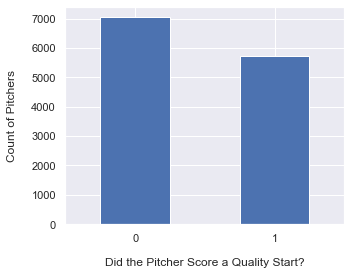

In [3]:
sns.set(font_scale=1)
df['QS_lbl'].value_counts().plot(kind='bar', figsize=(5, 4), rot=0)
plt.xlabel("Did the Pitcher Score a Quality Start?", labelpad=14)
plt.ylabel("Count of Pitchers", labelpad=14);

In [4]:
(df['QS_lbl'].value_counts(normalize = True)*100).round(1)

0    55.2
1    44.8
Name: QS_lbl, dtype: float64

We're working with a pretty balanced data set. The number of games without a QS outweigh those with a QS by 10%, but this is not a concerning level of imbalance. Let's check our null values next and then think through how we should impute them.

In [5]:
nulls = df.isnull().sum()
nulls[nulls > 0]

Pit           1
Str           1
StL           1
StS           1
GB            1
FB            1
LD            1
PU            1
Unk           1
aLI           1
WPA           1
acLI          1
cWPA          1
RE24          1
WHIP          1
BABIP         7
HR/FB        22
GB/FB         4
K%            1
BB%           1
BAA           2
K%-BB%        1
Pit/IP        1
LD%           5
FB%           4
PU%           7
GB%           7
BABIP_avg     1
HR/FB_avg     2
GB/FB_avg     1
BAA_avg       1
LD%_avg       1
FB%_avg       1
PU%_avg       1
GB%_avg       1
dtype: int64

Given the size of the data set, the number of null values is really small. Let's replace any infinities (due to ratios) with NaNs and then simply back fill each of the NaNs. This will fill each NaN with the value ahead of it.

In [6]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(method = 'bfill')

No more nulls are in any columns.  Let's drop some of the columns that will not be used in our modeling or EDA. Then, we can start building correlation matrices for our features. We'll start by looking at four main groups of features. Within these groups there are many variations of similar variables which we will later narrow down using a feature selection technique called mutual information classification.

In [7]:
df = df.drop(['Inngs', 'starts', 'num_inngs', 'Opp_lbl', 'Opp_x', 'Gcar'], axis = 1)

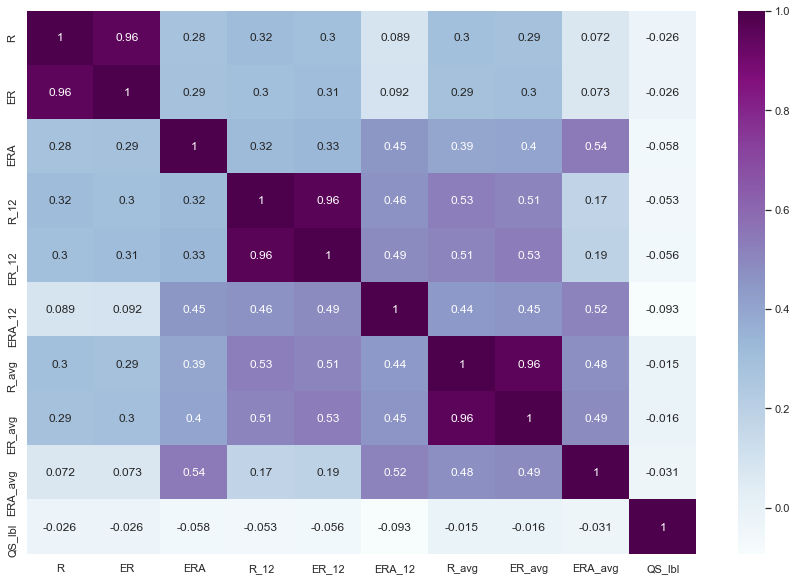

In [8]:
R = df[['R', 'ER', 'ERA', 'R_12', 'ER_12', 'ERA_12', 'R_avg', 'ER_avg', 'ERA_avg', 'QS_lbl']]
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(R.corr(), annot = True, cmap = 'BuPu', fmt = '.2g', ax = ax);

The row to analyze closely is the bottom one, where you can see the relationship between *QS_lbl* and all of the run related features. Almost across the board, we can see negative relationships but none of them can be considered significant. Earned runs are an input to quality starts, so it is somewhat surprising that there is no correlation. As we go through the feature selection process, we will monitor whether runs provides any information about the dependent variable.

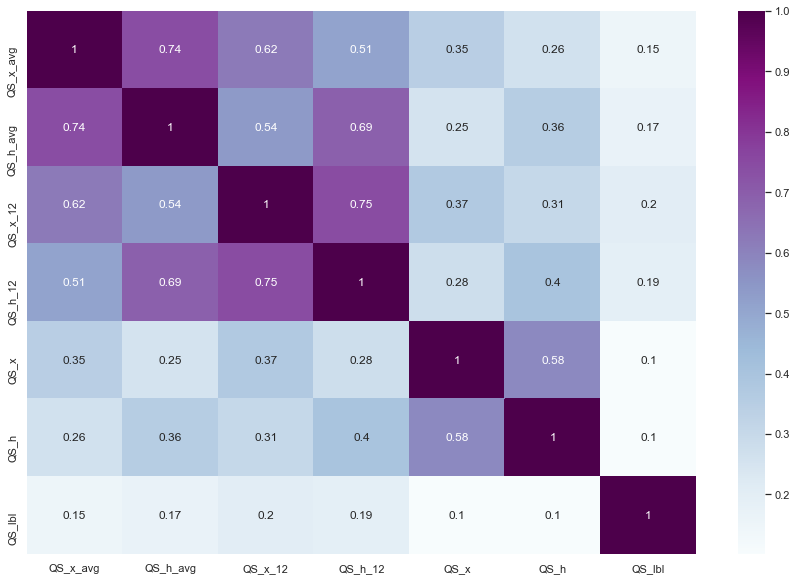

In [9]:
QS = df[['QS_x_avg', 'QS_h_avg', 'QS_x_12', 'QS_h_12', 'QS_x', 'QS_h', 'QS_lbl']]
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(QS.corr(), annot = True, cmap = 'BuPu', fmt = '.2g', ax = ax);

Using variations of quality start as a predictor is likely to get us valuable insights. The above matrix shows us some correlation between previous quality starts and our target. The QS average over the last 12 games showed a 20% correlation, while the 'High Value' QS showed a 19% correlation. Still, no features we have seen so far in this data set have shown strong relationships with the target. Let's look at strike related features.

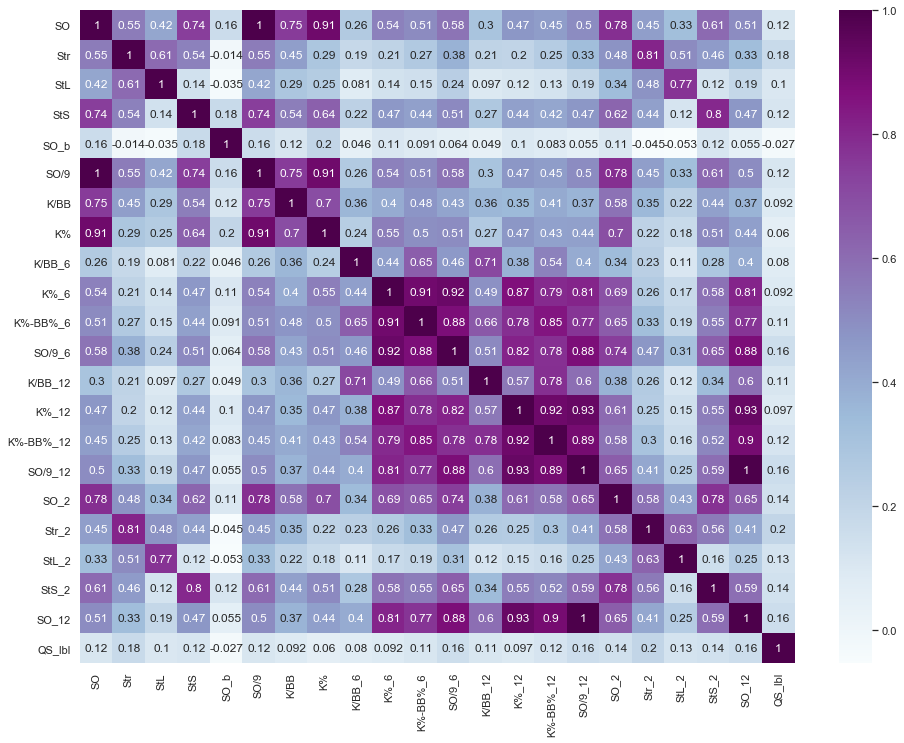

In [10]:
SO = df[['SO', 'Str', 'StL', 'StS', 'SO_b', 'SO/9', 'K/BB', 'K%', 'K/BB_6', 'K%_6', 'K%-BB%_6', 'SO/9_6', 'K/BB_12',
        'K%_12', 'K%-BB%_12', 'SO/9_12', 'SO_2', 'Str_2', 'StL_2', 'StS_2', 'SO_12', 'QS_lbl']]
fig, ax = plt.subplots(figsize=(16,12)) 
sns.heatmap(SO.corr(), annot = True, cmap = 'BuPu', fmt = '.2g', ax = ax);

These features show similar strength in relationship to the target as the top QS features did. Interestingly, there is quite a strong relationship between strikes last game and whether the pitcher records a QS next game (18% correlation). We can also see relatively strong correlation in the rolling sum of the last two game features. We can expect strikes and quality starts to both play an important part in our modeling.

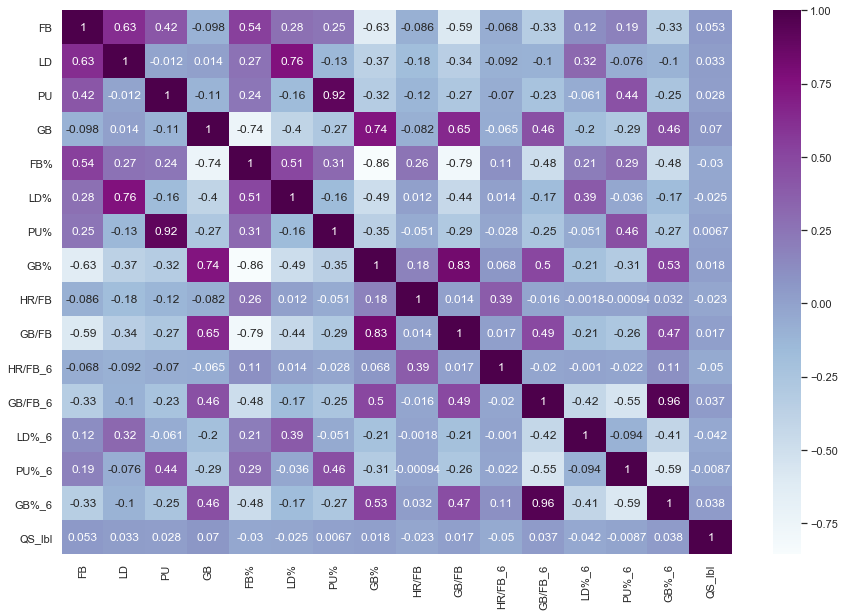

In [11]:
H = df[['FB', 'LD', 'PU', 'GB', 'FB%', 'LD%', 'PU%', 'GB%', 'HR/FB', 'GB/FB', 'HR/FB_6', 'GB/FB_6', 
        'LD%_6', 'PU%_6', 'GB%_6', 'QS_lbl']]
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(H.corr(), annot = True, cmap = 'BuPu', fmt = '.2g', ax = ax);

The ball type correlation matrix is the last one we'll analyze. Here, there is clearly no correlation across variables. It's possible that these features have more of a non linear relationship with the target though. We'll monitor whether they get selected in our mutual information classification later on. 

In our next steps, we will create two groups of plots. The first will help us get a sense of the relationship between fielding/batting features with our target and then we can look at bar plots of some efficiency measures on their own.

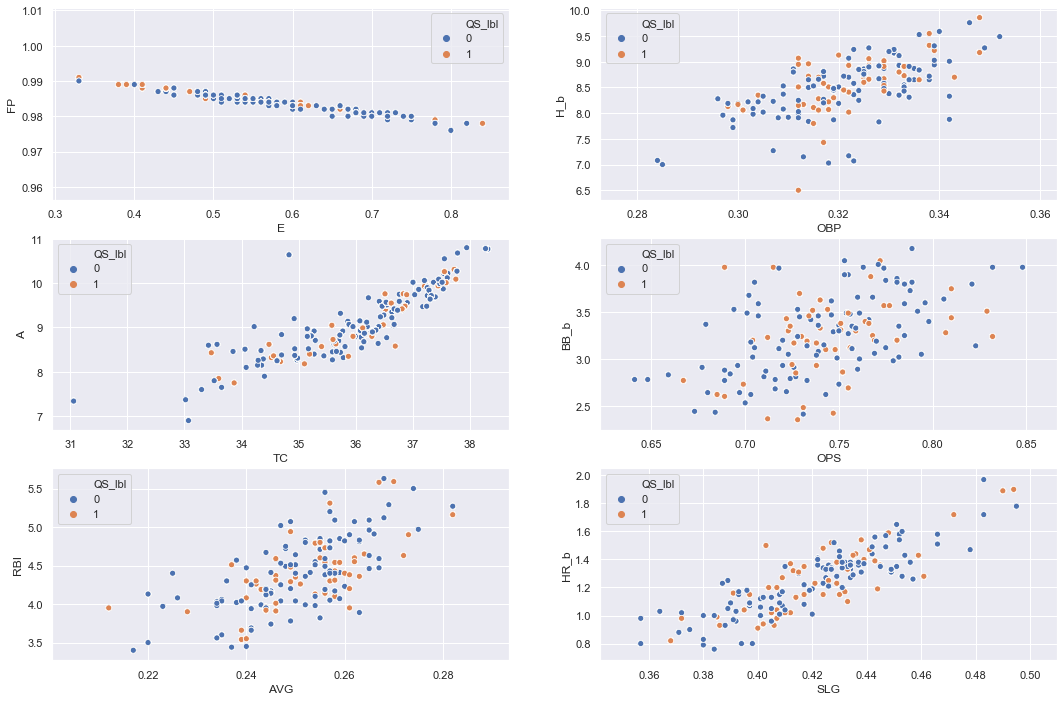

In [12]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (18, 12))
sns.scatterplot(x = 'E', y = 'FP', hue = 'QS_lbl', data = df, ax = axs[0, 0], legend = 'brief');
sns.scatterplot(x = 'TC', y = 'A', hue = 'QS_lbl', data = df, ax = axs[1, 0], legend = 'brief');
sns.scatterplot(x = 'AVG', y = 'RBI', hue = 'QS_lbl', data = df, ax = axs[2, 0], legend = 'brief');
sns.scatterplot(x = 'OBP', y = 'H_b', hue = 'QS_lbl', data = df, ax = axs[0, 1], legend = 'brief');
sns.scatterplot(x = 'OPS', y = 'BB_b', hue = 'QS_lbl', data = df, ax = axs[1, 1], legend = 'brief');
sns.scatterplot(x = 'SLG', y = 'HR_b', hue = 'QS_lbl', data = df, ax = axs[2, 1], legend = 'brief');

The features above all show positive correlation with one another to varying degrees. The plot on the top left comparing Fielding Errors with Fielding Percentage seems to show more quality starts on the left hand side of the plot, indicating that better fielding may contribute to the play of a pitcher in his next start. The other plots do not show any clear trends. 

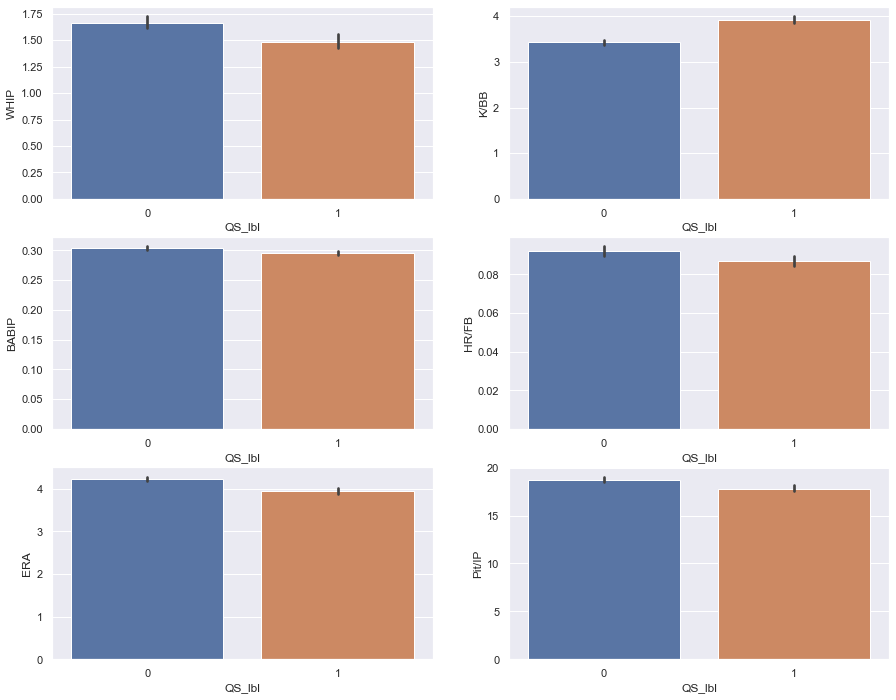

In [13]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 12))
sns.barplot(x = 'QS_lbl', y = 'WHIP', data = df, ax = axs[0, 0]);
sns.barplot(x = 'QS_lbl', y = 'BABIP', data = df, ax = axs[1, 0]);
sns.barplot(x = 'QS_lbl', y = 'ERA', data = df, ax = axs[2, 0]);
sns.barplot(x = 'QS_lbl', y = 'K/BB', data = df, ax = axs[0, 1]);
sns.barplot(x = 'QS_lbl', y = 'HR/FB', data = df, ax = axs[1, 1]);
sns.barplot(x = 'QS_lbl', y = 'Pit/IP', data = df, ax = axs[2, 1]);

Each of the features above provide valuable information about the target. The most noticeable of which, is the importance of WHIP (walks & hits per inning pitched). We can see quite clearly that pitchers who record a QS next start have a considerably lower WHIP. The other features tell a similar story as well.

### Modeling

From our EDA, we learned important information regarding the relationships between our features and the target. Visualizing our features in this way can help us explain the models we will build later. By looking at the correlation matrices, scatterplots, and bar charts, we can see that predicting a quality start next game using our data is likely to be challenging. The highest correlation we saw was 20% for any of our variables and the scatterplots did not show any meaningful trends. However, to set expectations again, our goal in this next section is mainly to produce two pieces of information.

First, we want to be able to stack rank pitchers according to their probability of recording a quality start next game. So  rather than building a binary classification model that decides for us, we want to build a model with more flexibility that can tell us when it is uncertain about the outcome and to quantify that uncertainty. During a season, this gives us more information to make a sound decision on our own when necessary. Second, any insights we can pull from EDA and modeling will be very useful for our decision making during the season.

Given that we are looking to be able to rank pitchers by probability of QS, **the performance metric we will optimize for will be AUC or Area Under the Curve.** AUC gives us an aggregate measure of performance across all classification thresholds. A model with a perfect AUC would score 100%, indicating that the model was able to predict positive labels correctly at every classification threshold. The AUC works well for our needs because it is scale and threshold invariant. It measures how well predictions are ranked, rather than absolute values. And it's not as concerned with minimizing one kind of classification error, but instead measures the overall quality of the model's predictions.

#### Train-Validation-Test Split

We can start by defining our train, validation, and test sets. The test set should represent the most recent data we have in order to model reality as closely as possible. We'll set the shortened 2020 season as our test case and assess our model's performance on this data set at the very end of this section.

We want the training set to contain most of our observations, so we will set the validation set to July 2019 to September 2019. Anything before July will fall into the training set. This gives the validation and test set a similar number of observations.

In [14]:
train = df[df['date'] < '2019-07-01']
val = df[(df['date'] >= '2019-07-01') & (df['date'] < '2019-09-30')]
test = df[df['year'] > 2019]

In [15]:
#drop labels and reset index

X_train = train.drop(['QS_lbl'], axis = 1).reset_index(drop = True)
X_valid = val.drop(['QS_lbl'], axis = 1).reset_index(drop = True)
X_test = test.drop(['QS_lbl'], axis = 1).reset_index(drop = True)

In [16]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(9983, 218)
(1547, 218)
(1234, 218)


Next, we must call out categorical columns separately and one hot encode each. We'll drop team because the quality of the teams likely vary too much season to season.

In [17]:
cat_cols = X_train.select_dtypes(['object']).drop(columns = ['name', 'Tm']).columns

In [18]:
#one hot encode categorical columns

from sklearn.preprocessing import OneHotEncoder

onehoter = OneHotEncoder(sparse = False)
onehoter.fit(X_train[cat_cols])
onehot_cols = onehoter.get_feature_names(cat_cols)
x_train_onehot = pd.DataFrame(onehoter.transform(X_train[cat_cols]), columns = onehot_cols)
x_valid_onehot = pd.DataFrame(onehoter.transform(X_valid[cat_cols]), columns = onehot_cols)
x_test_onehot = pd.DataFrame(onehoter.transform(X_test[cat_cols]), columns = onehot_cols)

With the categorical features one hot encoded, we can turn our attention to the numeric features. Let's drop all the categorical features and other features we do not want to bring into our models and store these into numeric variables.

In [19]:
x_train_num = X_train.drop(['Dec', 'Tm', 'H/A_x', 'H/A_lbl', 'Rank', 'Rank_f', 'name', 'year', 'date', 'Gtm'], axis = 1)
x_valid_num = X_valid.drop(['Dec', 'Tm', 'H/A_x', 'H/A_lbl', 'Rank', 'Rank_f', 'name', 'year', 'date', 'Gtm'], axis = 1)
x_test_num = X_test.drop(['Dec', 'Tm', 'H/A_x', 'H/A_lbl', 'Rank', 'Rank_f', 'name', 'year', 'date', 'Gtm'], axis = 1)

Next, we can standardize our numeric features and then join the onehot encoded features to give us a data set ready for modeling.

In [20]:
#initiate standard scaler
#fit to training data
#apply to all data sets

from sklearn.preprocessing import StandardScaler

znormalizer = StandardScaler()
znormalizer.fit(x_train_num)
X_train_norm = pd.DataFrame(znormalizer.transform(x_train_num), columns = x_train_num.columns)
X_valid_norm = pd.DataFrame(znormalizer.transform(x_valid_num), columns = x_valid_num.columns)
X_test_norm = pd.DataFrame(znormalizer.transform(x_test_num), columns = x_test_num.columns)
X_train_norm.head()

,DR,IP,H,R,ER,BB,SO,HR,HBP,ERA,...,BAA_avg,K%-BB%_avg,Pit/IP_avg,LD%_avg,FB%_avg,PU%_avg,GB%_avg,SO/9_avg,BB/9_avg,HR/9_avg
0,4.308893,-0.400961,-1.106723,-0.884935,-0.814993,2.430996,-1.295021,-0.889878,-0.451147,-0.886732,...,-1.982004,-5.490634,0.618334,-1.655182,-0.019853,2.253344,-0.808724,-2.882905,6.656545,-2.918757
1,2.761979,1.069385,-1.106723,-1.381998,-1.330882,0.147033,0.278709,-0.889878,3.720970,-1.297744,...,-3.028901,-2.382330,-0.139170,-3.049633,-1.232460,2.913354,0.511432,-1.137044,3.510016,-2.918757
2,-0.138486,1.069385,-1.562572,-0.387872,-0.299105,0.908354,0.278709,0.262347,-0.451147,-1.035479,...,-3.737096,-1.799523,-0.315544,-2.770743,-1.232460,2.583349,0.804801,-0.502186,3.139836,-1.512553
3,-0.283509,-1.136135,0.260824,0.109192,0.216784,3.192318,-0.901588,-0.889878,-0.451147,-0.671440,...,-2.105169,-2.576599,-0.028371,-1.934072,-0.828258,2.253344,0.658117,-0.898972,4.435466,-1.864104
4,-0.235168,-1.136135,0.716674,1.600381,1.764449,2.430996,-0.901588,1.414571,-0.451147,-0.025565,...,-0.811943,-2.965137,0.114085,-2.212962,-0.558790,1.593334,0.804801,-1.137044,4.990735,-0.457900


In [21]:
#join onehot encoded features to numeric

X_train = X_train_norm.join(x_train_onehot, how = 'left', rsuffix = '_oh')
X_valid = X_valid_norm.join(x_valid_onehot, how = 'left', rsuffix = '_oh')
X_test = X_test_norm.join(x_test_onehot, how = 'left', rsuffix = '_oh')

Let's not forget our labels. We want QS labels for our train, validation, and test sets. We need to subset these and reset their indices.

In [22]:
y_train = train['QS_lbl'].reset_index(drop = True)
y_valid = val['QS_lbl'].reset_index(drop = True)
y_test = test['QS_lbl'].reset_index(drop = True)

In our next step, we will narrow down our feature set. Most of the features in our data set either do not explain the variance in our target variable or repeat information already captured in other features. We can reduce the dimensionality of the data set by applying a method called mutual information classification.

Mutual information measures the dependency between two random variables. If the variables are independent, the mutual information score will be 0. Higher values mean higher dependencies. The function relies on methods used to estimate entropy from k nearest neighbour distances.

In the code block below, we have selected only 50 of the features from the original data set. We iteratively tested selecting a different number of features using our model's predictions on the validation set before deciding on 50 features.

In [23]:
#run mutual info classification
#convert output to list and show 50 highest mutual information features

from sklearn.feature_selection import mutual_info_classif
import heapq

mi_score = mutual_info_classif(np.array(X_train), y_train, random_state = 7)

mi = mi_score.tolist()
num = 50

m = heapq.nlargest(num, enumerate(mi), key = lambda mi: mi[1])

In [24]:
X_col = [i[0] for i in m]
X_train = X_train.iloc[:, X_col]

In [25]:
X_valid = X_valid.iloc[:, X_col]
X_test = X_test.iloc[:, X_col]

In [26]:
X_train.columns.tolist()

['QS_h_12',
 'K/BB_6',
 'StS',
 'Pit_12',
 'AB_12',
 'SO_avg',
 'K%_avg',
 'SO_2',
 'Str_12',
 'StL_12',
 'QS_x_12',
 'IP_12',
 'StS_2',
 'BF_12',
 'SO/9',
 'BF_avg',
 'WHIP',
 'K/BB',
 'K%-BB%_6',
 'QS_x_avg',
 'ER_12',
 'GSc_12',
 'DR_12',
 'StS_12',
 'Rank_17',
 'Rank_11',
 'SO_12',
 'Str_2',
 'LD%',
 'BF',
 'SO/9_avg',
 'CS_avg',
 'SB_avg',
 'Rank_f_27',
 'AB_avg',
 'ER_avg',
 'Pit',
 'BB/9_12',
 'WPA_avg',
 'HR/FB',
 'QS_h_avg',
 'FB_avg',
 'Rank_f_3',
 'GB/FB',
 'TC',
 'H_b',
 'HR/9_6',
 'Rank_f_10',
 'IBB_avg',
 'LD%_12']

With the 50 features selected by the mutual information classification above, we are finally ready to begin modeling. We will build three different models - we will begin with a Decision Tree classifier, then build a Random Forest classifier, and then a Support Vector Machine. While the decision tree classifier is useful for model intepretation, we will not be selecting it as the final model given our needs. For one, decision trees are often unstable. Changes to the data can cause large differences in the output of the tree. But the more important reason is that decision trees will not give us the flexibility we need when ranking pitchers. The tree outputs classes of probabilities, which lead to pitchers often times, falling into the same probability bucket. This will make it hard to differentiate between pitchers when making decision in the future.

Having said this, decision trees are one of the best ways to understand the features in our data set better, so we will still build one and then use the insights it provides and also compare its output to the other models. 

In [27]:
#use greedy approach
#iteratively increase max leaf nodes until performance drop off

from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(min_samples_leaf = 2, max_leaf_nodes = 8, min_samples_split = 2)
dtree.fit(X_train, y_train)

y_dtree_train = dtree.predict(X_train)
y_dtree_valid = dtree.predict(X_valid)

In [28]:
from sklearn.metrics import roc_auc_score

print("Training AUC: {:.1f}%.".format(roc_auc_score(y_train, y_dtree_train)*100))
print("Validation AUC: {:.1f}%.".format(roc_auc_score(y_valid, y_dtree_valid)*100))

Training AUC: 57.3%.
Validation AUC: 58.0%.


We get a similar AUC on both our train and validation sets. Let's visualize our tree next.

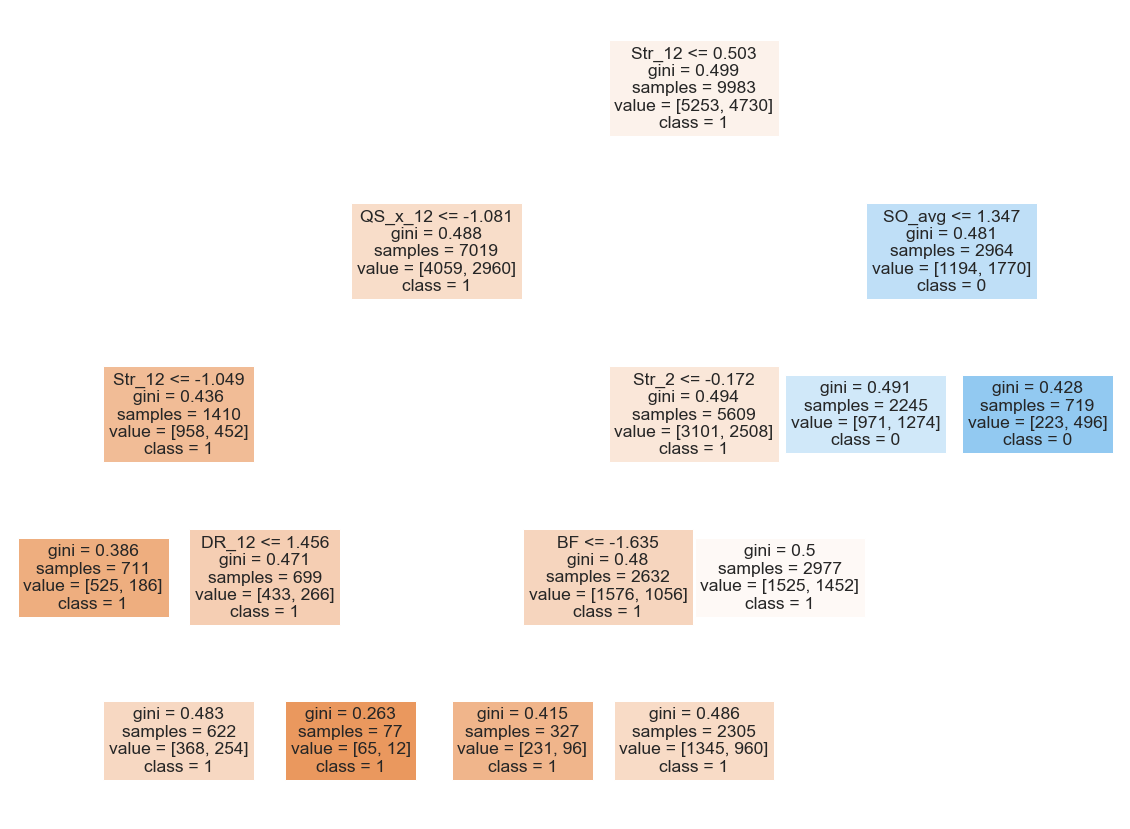

In [38]:
from sklearn import tree
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 15)) 
_ = tree.plot_tree(dtree,
               feature_names=X_train.columns,  
               class_names=['1', '0'],
               filled=True);

The decision tree tells us a lot about the importance of our features. At the root node, we can see that a pitcher's number of strikes average over his last 12 games is the feature with the highest Gini coefficient. This is a recurring theme, as the rolling sum of the pitcher's last two games is also an important feature. These features also had high relative correlation during our EDA process. 

Once again, no variation of runs are in the tree above. This could be because a pitcher's skill is more directly related to two factors - how good he is at making batters miss and how much he actually plays. Notice other features that show importance above are the 12 Game Average Days Rest feature and Batters Faced feature. Pitchers that face more batters and also play more often are probably more skilled as well. 

Next, we will build a Random Forest Classifier, which builds many weak Decision Trees and chooses the most common prediction. This should result in a more robust and stable model that can also provide us feature importance scores. Let's begin by doing a grid search for the optimal parameters.

In [30]:
#set parameter grid
#initialize rf regressor
#perform grid search - 2 cvs
#print best parameters

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [6, 8],
    'max_features': [4, 6],
    'n_estimators': [800, 1000, 1200]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:   22.5s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   29.9s finished


{'bootstrap': True, 'max_depth': 6, 'max_features': 4, 'n_estimators': 1200}

The parameters output by the grid search can now be used in our prediction on the validation set.

In [90]:
#use optimal parameters from grid search
#run rf classifier

from sklearn.ensemble import RandomForestClassifier

hypers = {"n_estimators": 1200, "max_features": 4, "max_depth": 6, 
          "min_samples_leaf": 2, "min_samples_split": 2}
clf_rf = RandomForestClassifier(verbose = True, **hypers).fit(X_train, y_train)

y_hat_train_rf = clf_rf.predict(X_train)
y_hat_valid_rf = clf_rf.predict(X_valid)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:   17.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.3s finished


In [91]:
print("Training AUC: {:.1f}%.".format(roc_auc_score(y_train, y_hat_train_rf)*100))
print("Validation AUC: {:.1f}%.".format(roc_auc_score(y_valid, y_hat_valid_rf)*100))

Training AUC: 62.5%.
Validation AUC: 59.9%.


The Random Forest performance is slightly stronger than the Decision Tree. The variance from train to validation is also small. Let's check the top features by their importance next and then train a SVM as our final model.

In [92]:
#display top 10 features from rf

var_imp = pd.DataFrame({"feature": X_train.columns, "importance": clf_rf.feature_importances_})
var_imp.sort_values(by = 'importance', ascending = False).head(10)

,feature,importance
8,Str_12,0.056975
11,IP_12,0.056241
27,Str_2,0.055493
4,AB_12,0.048304
13,BF_12,0.044479
10,QS_x_12,0.040440
3,Pit_12,0.040306
34,AB_avg,0.035229
0,QS_h_12,0.032595
36,Pit,0.032347


The theme from the Decision Tree above continued here with the average strikes over the last 12 games taking the top most important spot. Again, pitchers that play a lot seem to have a better probability of getting the QS. This table shows Innings Pitched over the last 12 as the second most important.

In [93]:
#set svm parameters
#fit to train set

from sklearn.svm import SVC

svmc = SVC(C = 1.3, gamma = 'auto', kernel = 'rbf', probability = True)
svmc.fit(X_train, y_train)

y_hat_train_svm = svmc.predict(X_train)
y_hat_valid_svm = svmc.predict(X_valid)

In [94]:
print("Training AUC: {:.1f}%.".format(roc_auc_score(y_train, y_hat_train_svm)*100))
print("Validation AUC: {:.1f}%.".format(roc_auc_score(y_valid, y_hat_valid_svm)*100))

Training AUC: 66.2%.
Validation AUC: 60.4%.


The SVM's performance is a little higher than the Random Forest. The difference being that the variance on the SVM is higher and we do not have much visibility into the SVM. Let's look at the ROC-AUC plot and then test these models on our test set before making a final decision.

In [95]:
#construct the roc curve
#calculate and show AUC by model

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc(models, model_names):
    plt.figure(0, figsize = [8, 7]).clf()
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    for ii, model in enumerate(models):
        y_prob_test = model.predict_proba(X_valid)[:, 1]
        fpr, tpr, threshold = roc_curve(y_valid, y_hat_valid_svm, pos_label = 1)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label = "{} AUC = {:0.2f}".format(model_names[ii], roc_auc))

    plt.legend(loc = 'lower right');

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.5s finished


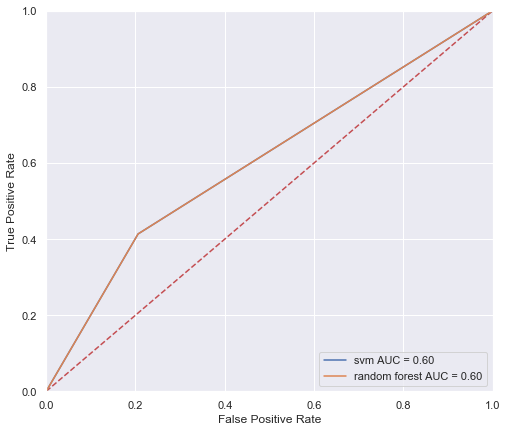

In [96]:
plot_roc([svmc, clf_rf], ['svm', 'random forest'])

In [97]:
y_rf_test = clf_rf.predict(X_test)
y_svm_test = svmc.predict(X_test)

print("Random Forest Test AUC: {:.1f}%.".format(roc_auc_score(y_test, y_rf_test)*100))
print("SVM Test AUC: {:.1f}%.".format(roc_auc_score(y_test, y_svm_test)*100))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.2s finished


Random Forest Test AUC: 59.3%.
SVM Test AUC: 60.3%.


The SVM's performance edges out the Random Forest on both the validation and test sets, so we will move forward with this model. Let's apply the probabilities for each pitcher onto the test set and look at what the model is showing for a few of the pitchers.

In [98]:
qs_test_prob = pd.DataFrame(svmc.predict_proba(X_test)).reset_index(drop = True)

In [99]:
test = test.reset_index(drop = True)
test = test.join(qs_test_prob)

In [100]:
test[['name', 'Tm', 'QS_lbl', 0, 1]].tail()

,name,Tm,QS_lbl,0,1
1229,youngal,ARI,0,0.624277,0.375723
1230,youngal,ARI,0,0.607653,0.392347
1231,youngal,ARI,0,0.606075,0.393925
1232,youngal,ARI,0,0.614978,0.385022
1233,youngal,ARI,0,0.604719,0.395281


In [101]:
qs_prob = pd.DataFrame(test.groupby('name')[1].mean()).sort_values(1, ascending = False).reset_index()
qs_prob = qs_prob.rename(columns = {1: 'Average QS Probability', 'name': 'Pitcher Name'})

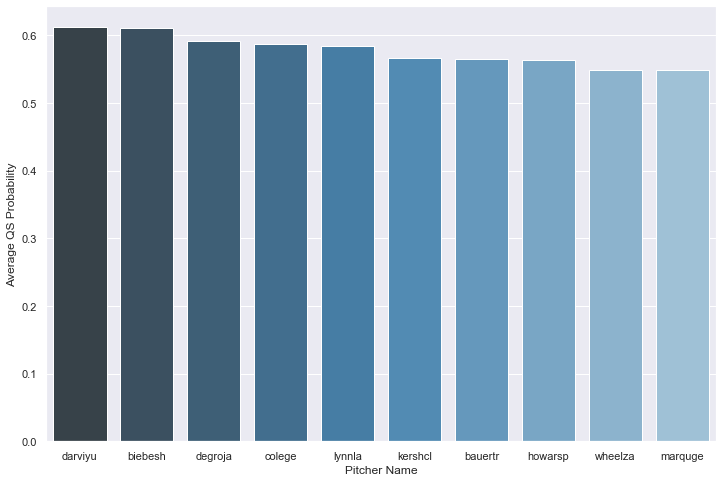

In [107]:
fig, ax = plt.subplots(figsize=(12,8)) 
sns.barplot(x = 'Pitcher Name', y = 'Average QS Probability', data = qs_prob.head(10), ax = ax, palette = 'Blues_d');

The average QS probability of the top 10 pitchers for the 2020 season are shown above. Most of the pitchers that the model has scored highly also ended up on the leader board for quality starts at the end of the season, which is a good sign. Interestingly, the top pitcher only has an average QS probability of less than 65%, indicating the model's uncertainty in a typical game's outcome. This makes sense because the model is attempting to predict the outcome of just one sample. Within that context, we can be satisfied with the performance of our final model.

## Takeaways

The next MLB season begins in April, where we will get a real time opportunity to see how this model performs. In this process, we scraped over 30,000 rows of data, over 300 different features, and narrowed it down to a SVM model that used 50 features to predict QS performance with a 60% AUC. 

Although the model showed quite a bit of underfitting, there were many insights that we were able to take away, such as the importance of strikes & how runs are not as important as we thought. Also, the model will help us quantifiably measure the uncertainty when streaming pitchers from the waiver wire during a season. The flexibility of having a probability for every pitcher in the MLB in their very next start will be a major competitive advantage even though the model may not get it right all the time.

In the future, there are many things that could improved. Because I only had a month to spend on this project, there were certain features that we could not explore. Specifically, the importance of pitcher vs individual batter data and pitcher-catcher tandems. Also, it may be useful to even ask a different Quality Start related question such as, how many Quality Starts can be expected for a pitcher over his next 5 games? A prediction like this would be simpler because the model would have more than one sample/game to predict on. As the season starts, we will update the how the model is used in production and how it is performing relative to expectations.